<a href="https://colab.research.google.com/github/evmpython/2_codigos_gerais/blob/main/01_ERA5_GEE_mapa_TEMPERATURA_e_ANOMALIA_por_mes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# Mapa de Temperatura e Anomalia para um Determinado `Mês`


---


 - Dados utilizados: [ERA5](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY_AGGR?hl=pt-br)
 - Variável utilizada: Temperatura do ar em 2 m
 - Informações sobre os dados:
    - Resolução espacial: 11 km
    - Resolução temporal: mensal
    - Período dos dados: 1950-2025/02
    
 - Criar [conta](https://earthengine.google.com/) no Google Earth Engine. Exemplo: https://www.youtube.com/watch?v=NHhgaprxWRw
 - Realizado e atualizado: Enrique V. Mattos - 18/03/2025



---



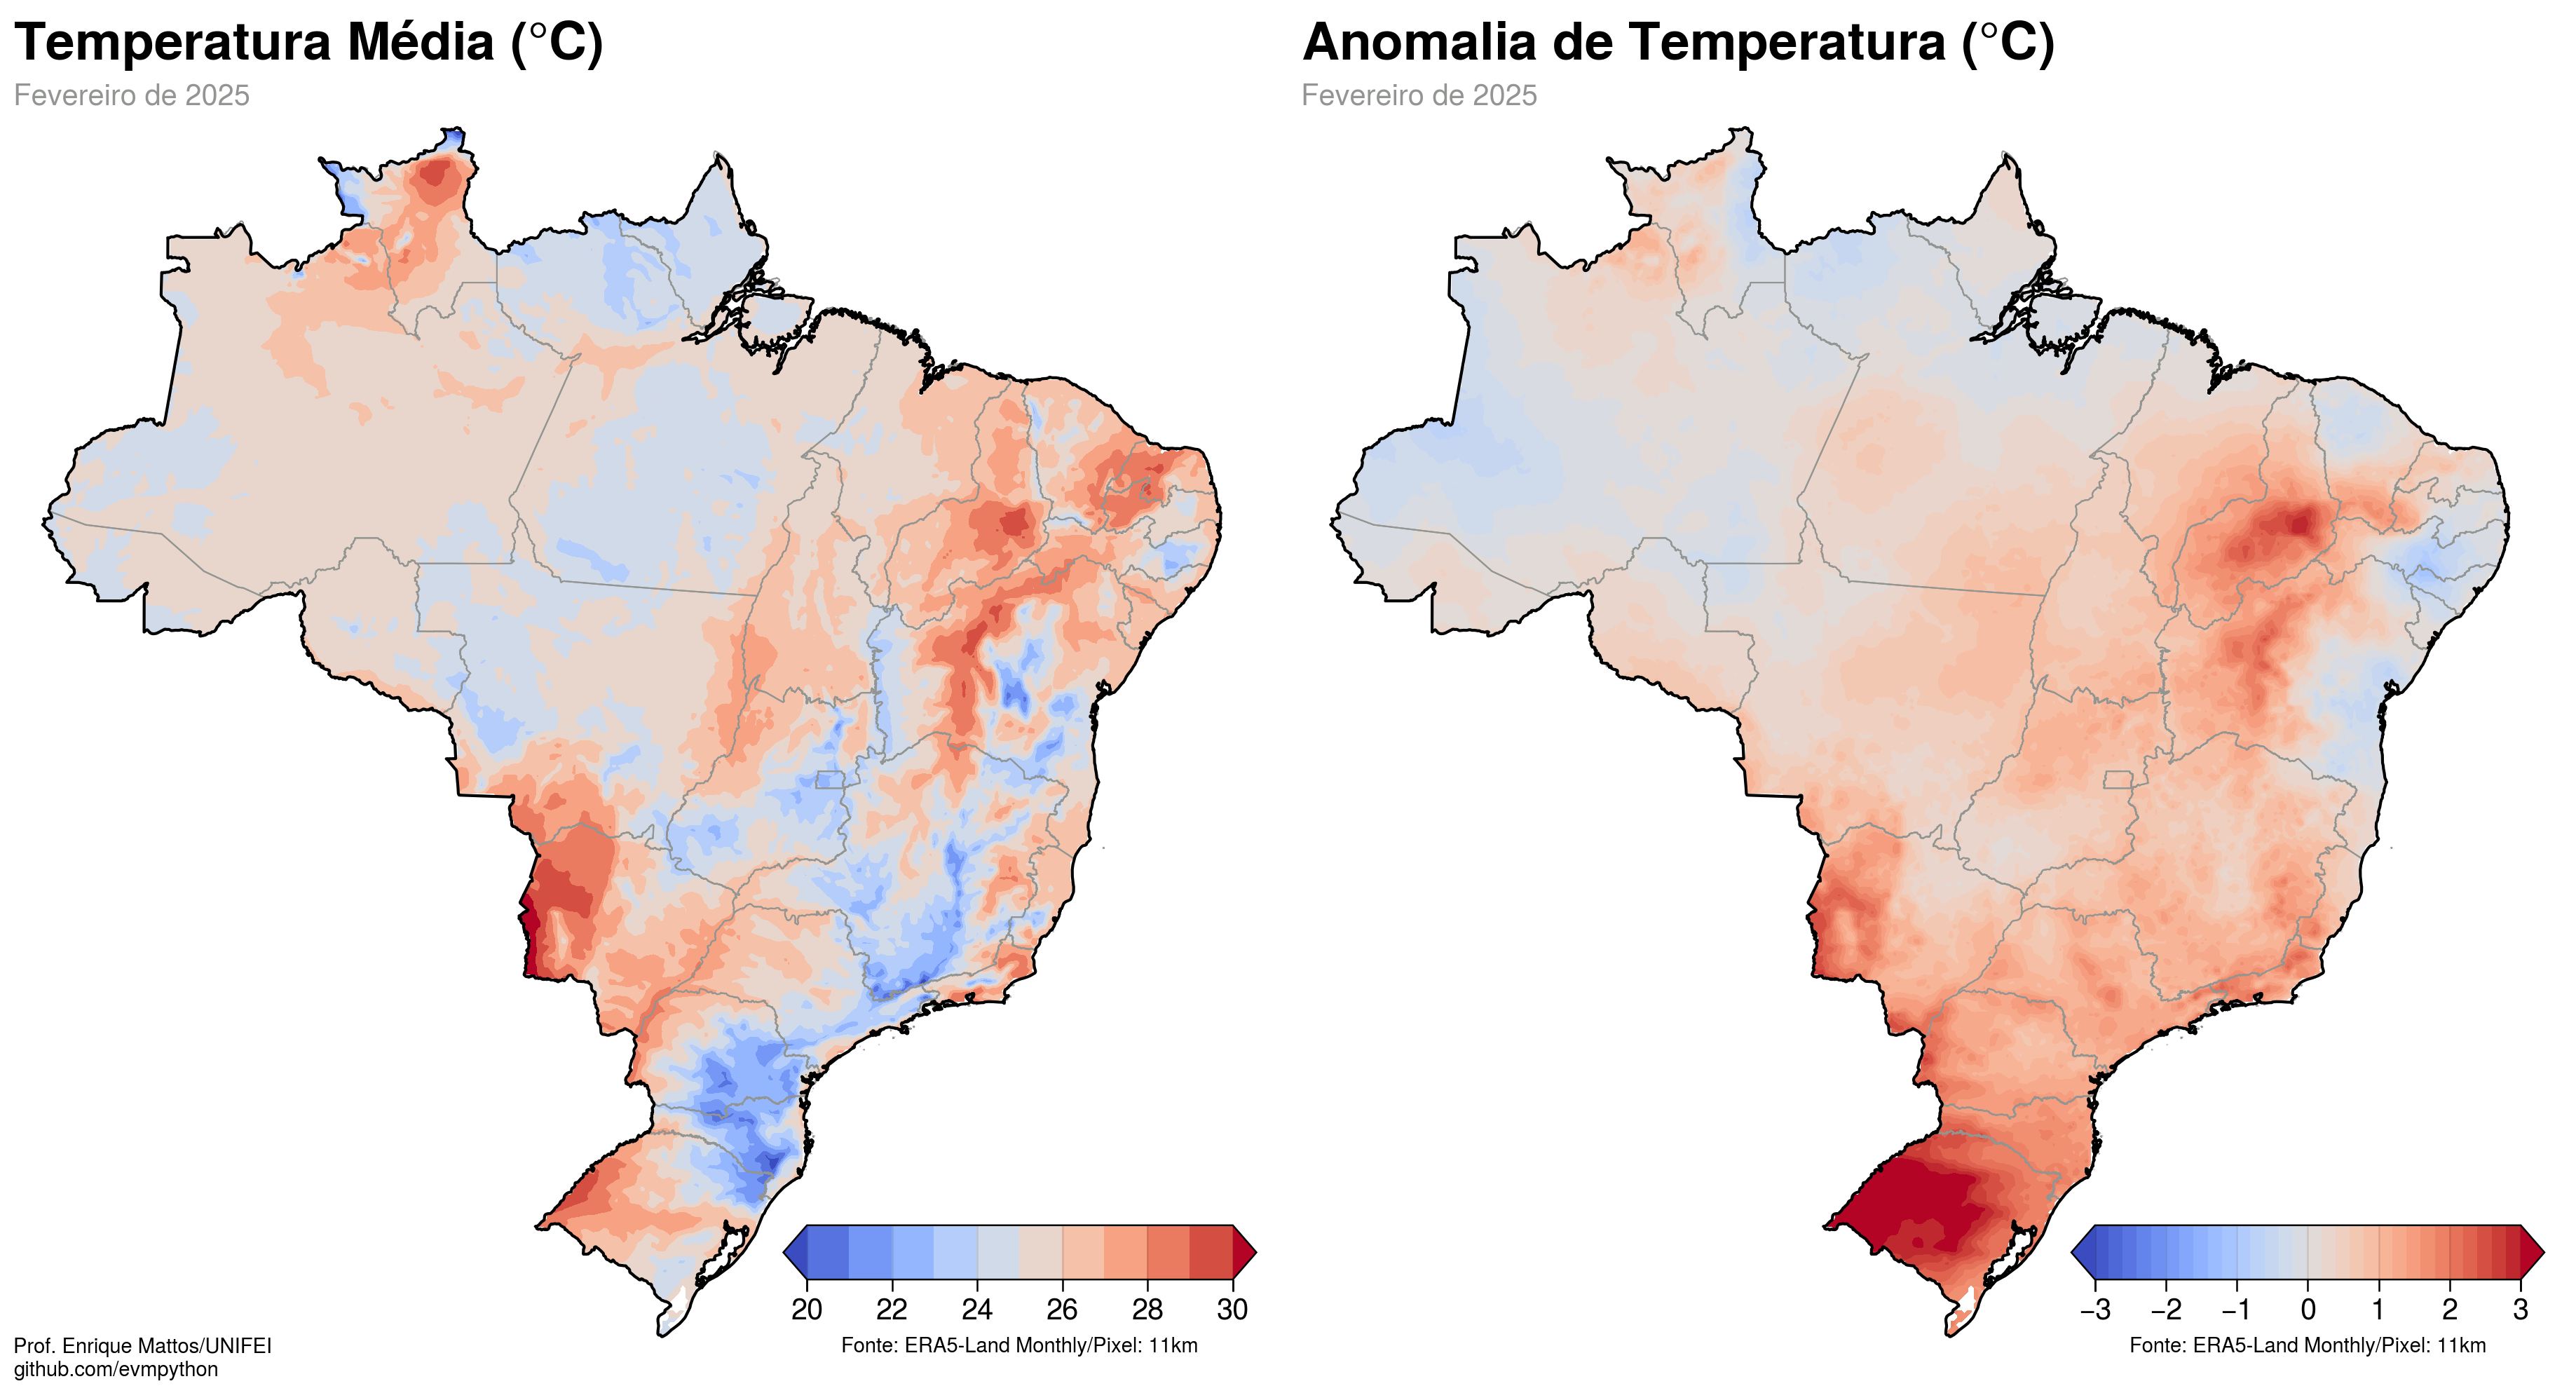



---



# Preparando o ambiente

In [1]:
#=========================================================================#
#                   Inicilizando o GEE e XEE
#=========================================================================#
# instalando Xee
!pip install -q xee

# importa bibliotecas
import ee
import xarray as xr
import time

# inicializando o GEE
ee.Authenticate()
ee.Initialize(project='ee-enrique', opt_url='https://earthengine-highvolume.googleapis.com')

#=========================================================================#
#              Instalando bibliotecas e montando o drive
#=========================================================================#
# instalações
!pip install -q ultraplot cartopy salem rasterio pyproj geopandas

# importa bibliotecas
import ultraplot as uplt
import salem
import warnings
warnings.filterwarnings("ignore")

# monta o drive
from google.colab import drive
drive.mount('/content/drive')

# define o caminho
dir = '/content/drive/MyDrive/PYHTON/00_GITHUB/5_ERA5/'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.4 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/ultraplot/__init__.py:77: UltraPlotWarning: Rebuilding font cache. This usually happens after installing or updating ultraplot.
  register_fonts(default=True)


Mounted at /content/drive


# Carregando os dados


In [24]:
%%time

# região de estudo
roi = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#roi = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo'))
#roi = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Paulo'))
#roi = ee.Geometry.Rectangle([-46.2009,-21.151596,-46.189293,-21.143079])

# carrega os dados de t2m
t2m_mensal = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')\
               .select('temperature_2m')\
               .filterDate('1990-01-01','2025-04-01')\
               .map(lambda img: img.subtract(273.15).copyProperties(img, img.propertyNames()))

# converte para Dataset
ds_t2m_mensal = xr.open_dataset(t2m_mensal,
                                engine = 'ee',
                                crs = 'EPSG:4326',
                                scale = 0.11,
                                geometry = roi.geometry())

# muda de "(time, lon, lat)" para "(time, lat, lon)"
ds_t2m_mensal = ds_t2m_mensal.transpose("time", "lat", "lon")

# mostrando os dados
ds_t2m_mensal

CPU times: user 82.2 ms, sys: 4.56 ms, total: 86.7 ms
Wall time: 2.64 s


<xarray.Dataset> Size: 246MB
Dimensions:         (time: 422, lon: 410, lat: 355)
Coordinates:
  * time            (time) datetime64[ns] 3kB 1990-01-01 ... 2025-02-01
  * lon             (lon) float64 3kB -73.93 -73.82 -73.71 ... -29.05 -28.94
  * lat             (lat) float64 3kB -33.7 -33.59 -33.48 ... 5.025 5.135 5.245
Data variables:
    temperature_2m  (time, lat, lon) float32 246MB ...
Attributes:
    crs:      EPSG:4326

# Calcula anomalia

In [25]:
%%time
# define o "ANO" e "MÊS"
ano, mes = '2025', '02'

# nome dos meses
nome_mes = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

# limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# leitura do shapefile do Brasil
shapefile_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')

# calculando a "CLIMATOLOGIA"
climatologia = ds_t2m_mensal['temperature_2m'].sel(time=slice('1990-01-01','2020-12-31')).groupby("time.month").mean("time")

# calculando a "ANOMALIA"
anomalia = ds_t2m_mensal['temperature_2m'].sel(time=slice(f'{ano}-{mes}',f'{ano}-{mes}')).groupby("time.month") - climatologia

# recorta o dado para região
anomalia = anomalia.salem.roi(shape=shapefile_brasil)

# recorta o dado para região
ds_t2m_mensal = ds_t2m_mensal.salem.roi(shape=shapefile_brasil)

CPU times: user 54.6 s, sys: 18.6 s, total: 1min 13s
Wall time: 2min 19s


In [26]:
ds_t2m_mensal

<xarray.Dataset> Size: 246MB
Dimensions:         (time: 422, lat: 355, lon: 410)
Coordinates:
  * time            (time) datetime64[ns] 3kB 1990-01-01 ... 2025-02-01
  * lon             (lon) float64 3kB -73.93 -73.82 -73.71 ... -29.05 -28.94
  * lat             (lat) float64 3kB -33.7 -33.59 -33.48 ... 5.025 5.135 5.245
Data variables:
    temperature_2m  (time, lat, lon) float32 246MB nan nan nan ... nan nan nan
Attributes:
    crs:         EPSG:4326
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [27]:
climatologia

<xarray.DataArray 'temperature_2m' (month: 12, lat: 355, lon: 410)> Size: 7MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [13.8377695, 12.425128 , 11.160694 , ...,        nan,
                nan,        nan],
        [12.922641 , 13.1506   , 11.691716 , ...,        nan,
                nan,        nan],
        [11.232303 , 13.236429 , 12.008731 , ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [13.685656 , 12.480205 , 11.342747 , ...,        nan,
                nan,        nan],
        [12.886085 , 13.274902 , 11.821063 , ...,        nan,
                nan,        nan],
        [11.224756 , 13.296016 , 12.052749 , ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [13.65363  , 12.380115 , 11.2057705, ...,        nan,
                nan,        nan],
        [12.825192 , 13.118991 , 11.678155 , ...,        nan,
                nan,        nan],
        [11.155658 , 13.169863 , 11.921429 , ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 3kB -73.93 -73.82 -73.71 ... -29.16 -29.05 -28.94
  * lat      (lat) float64 3kB -33.7 -33.59 -33.48 -33.37 ... 5.025 5.135 5.245
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    id:             temperature_2m
    data_type:      {'type': 'PixelType', 'precision': 'double'}
    crs:            EPSG:4326
    crs_transform:  [0.1, 0, -180.05, 0, -0.1, 90.05]

In [28]:
anomalia

<xarray.DataArray 'temperature_2m' (time: 1, lat: 355, lon: 410)> Size: 582kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2025-02-01
  * lon      (lon) float64 3kB -73.93 -73.82 -73.71 ... -29.16 -29.05 -28.94
  * lat      (lat) float64 3kB -33.7 -33.59 -33.48 -33.37 ... 5.025 5.135 5.245
    month    (time) int64 8B 2
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

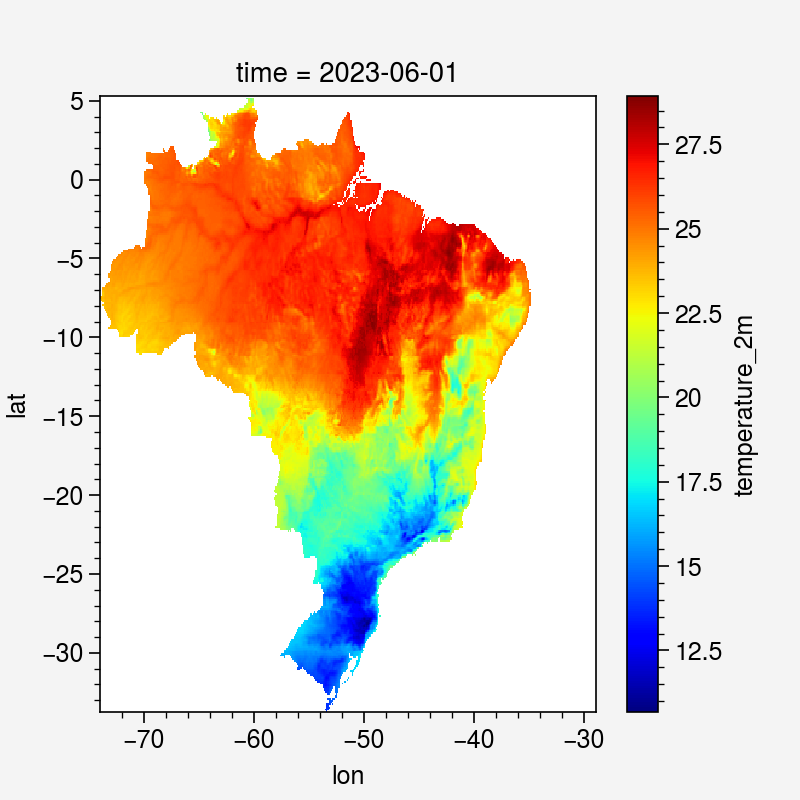

In [29]:
ds_t2m_mensal['temperature_2m'].loc['2023-06-01'].plot(x='lon', y='lat', cmap='jet')

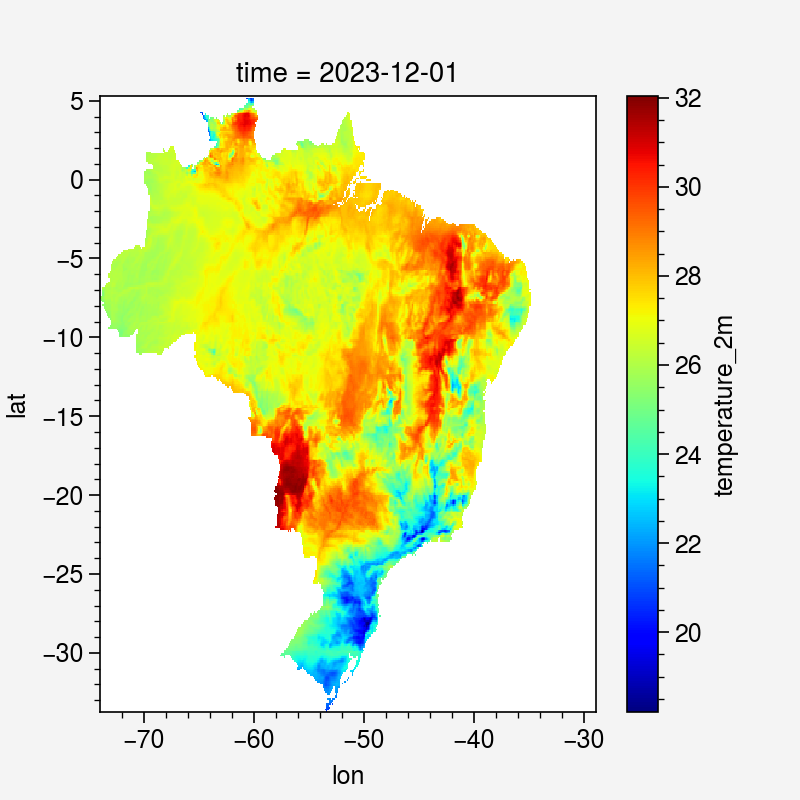

In [30]:
ds_t2m_mensal['temperature_2m'].loc['2023-12-01'].plot(x='lon', y='lat', cmap='jet')

# Mapa de `TEMPERATURA` e `ANOMALIA`  

CPU times: user 8.39 s, sys: 29.9 ms, total: 8.42 s
Wall time: 8.86 s


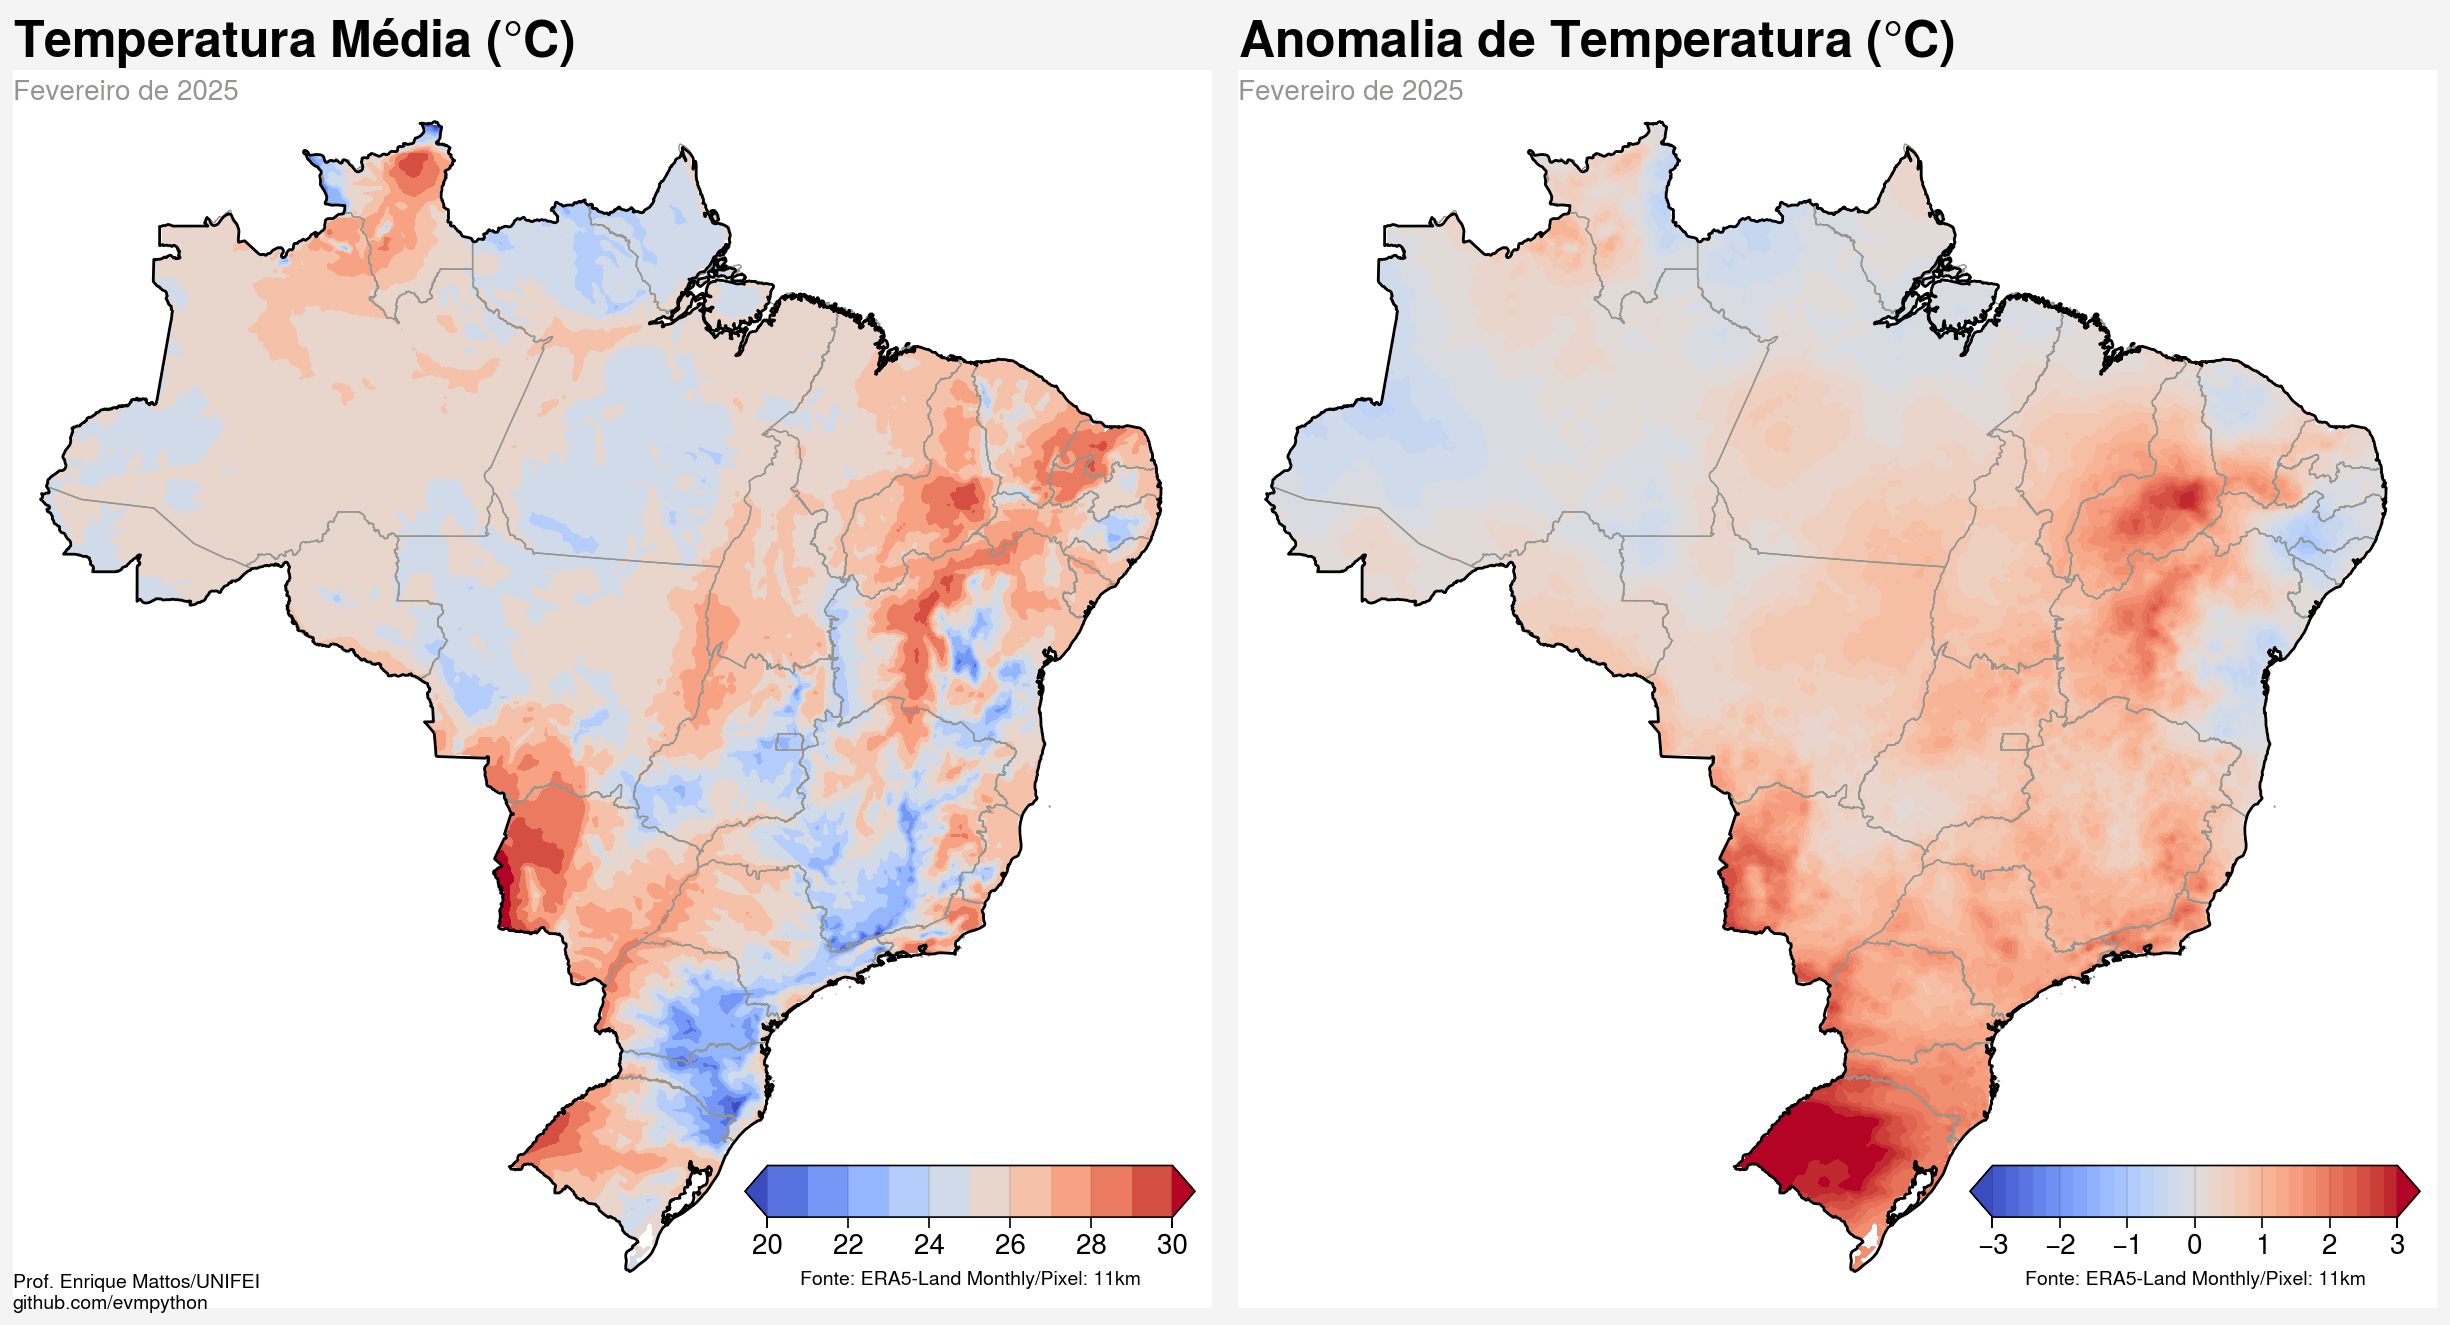

In [31]:
%%time
# cria a moldura da figura
fig, ax = uplt.subplots(axwidth=6, ncols=2, nrows=1, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          small='20px', large='25px',
          linewidth=0, grid=False)

# plota subtítulo
ax.text(lonmin, latmax-1.0, f'{nome_mes[int(mes)-1]} de {ano}', color='grey', fontsize=10)

#--------------------------------------------------------------#
#                     FIG-1: TEMPERATURA
#--------------------------------------------------------------#
# plota mapa
map1 = ax[0].contourf(ds_t2m_mensal['lon'],
                      ds_t2m_mensal['lat'],
                      ds_t2m_mensal['temperature_2m'].loc[f'{ano}-{mes}-01'],
                      cmap='coolwarm',
                      vmin=20, vmax=30,
                      levels=uplt.arange(20, 30, 1),
                      extend='both',
                      colorbar='best',
                      colorbar_kw={'label': 'Fonte: ERA5-Land Monthly/Pixel: 11km',
                                   'length': 18,
                                   'frameon': False,
                                   'ticklabelsize': 10,
                                   'labelsize': 7,
                                   'width': 2,
                                   'ticks': 2,
                                   'minorticks': False})

# título da figura
ax[0].format(title=f'Temperatura Média ($\degree$C)',
             titleloc='l',
             titleweight='bold',
             titlecolor='black')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[0])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])

# informação na figura
ax[0].annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

#--------------------------------------------------------------#
#                     FIG-2: ANOMALIA
#--------------------------------------------------------------#
# plota mapa
ax[1].contourf(anomalia['lon'],
               anomalia['lat'],
               anomalia[0,:,:],
               cmap='coolwarm',
               vmin=-3.0, vmax=3.0,
               levels=uplt.arange(-3.0, 3.0, 0.2),
               extend='both',
               colorbar='best',
               colorbar_kw={'label': 'Fonte: ERA5-Land Monthly/Pixel: 11km',
                            'length': 18,
                            'frameon': False,
                            'ticklabelsize': 10,
                            'labelsize': 7,
                            'width': 2,
                            'ticks': 1,
                            'minorticks': False})

# título da figura
ax[1].format(title=f'Anomalia de Temperatura ($\degree$C)',
             titleloc='l',
             titleweight='bold',
             titlecolor='black')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[1])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[1])

# salva figura
fig.save(f'{dir}output/Fig_1_ERA5_temperatura_e_anomalia_{ano}-{mes}.png', dpi=300)